In [1]:
import re
import string
import pandas as pd
import sys
import pickle
import numpy as np

# NLTK
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
%matplotlib inline

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
sys.path.append("/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages")

In [3]:
from textblob import TextBlob
import gensim
from gensim import corpora, models, similarities, matutils

2017-12-22 09:49:00,672 : INFO : Could not import Theano, will use standard float for default ShardedCorpus dtype.
2017-12-22 09:49:01,077 : INFO : 'pattern' package not found; tag filters are not available for English


In [4]:
# LOAD
file = 'coffee_elite'
f = open(file,'rb') 
df_elite = pickle.load(f) 
f.close()

file = 'coffee_nonelite'
f = open(file,'rb') 
df_nonelite = pickle.load(f) 
f.close()

In [5]:
df = pd.concat([df_elite, df_nonelite])

In [6]:
df.coffee.value_counts()

1    185469
Name: coffee, dtype: int64

In [7]:
# Create a stricter definition of coffeehouse
# Needs to be the first category and not include restaurants and ice cream places
coffee = lambda x: 1 if 'Coffee' in x[:9] and 'Ice Cream' not in x and 'Restaurant' not in x else 0

df['coffee_new'] = df['categories'].apply(coffee)

In [8]:
df.coffee_new.value_counts()

0    157903
1     27566
Name: coffee_new, dtype: int64

In [9]:
df = df[df.coffee_new == 1]

# Functions

In [10]:
# Preprocessing of Yelp reviews
def preprocessing(data):
    global df
    df = data
    alphanumeric = lambda x: re.sub(r"""\w*\d\w*""", '', x)
    punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())
    df['text'] = df.text.map(alphanumeric).map(punc_lower)
    
    """Exclude city names, common adjectives, and common chains"""
    
    cities = [x.lower() for x in df.city.unique().tolist()]
    stopwords = ['good', 'great', 'super', 'really', 'like', 'place', 'drink', 'just', 'love', 'ive'
                'starbucks', 'dutch bros', 'dunkin', 'coffee bean', 'tea leaf']
    stopwords = stopwords + cities
    
    for i in stopwords:
        df['text'] = df.text.map(lambda x: x.replace(i, ''))
        
    df = df.reset_index(drop=True)
    return df

In [11]:
# Display topics and words
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Pre-processing

In [12]:
preprocessing(df)

,average_stars,business_id,categories,city,coffee,cool_x,cool_y,date,elite,elite_years_count,...,review_id,stars_biz,stars_review,state,text,useful_x,useful_y,user_id,yelping_since,coffee_new
0,3.26,BtTCTHwoIfr3fBQjaOkpIw,"['Coffee & Tea', 'Food']",Toronto,1,0,50.0,2011-11-27,"[2011, 2016, 2014, 2012, 2013]",5.0,...,KBKcpUFeIz0Cox2WHvlulw,4,4.0,ON,of all the starbucks i frequent in this city t...,1.0,166.0,J76FnutwAI2PkkB4A-LNwg,2010-07-27,1
1,3.78,Q7rrhu3FJxTASTo46pT9vA,"['Coffee & Tea', 'Food']",Toronto,1,1,10.0,2010-04-11,"[2009, 2011, 2010]",3.0,...,qOxc8sUEQsZKt05HJDHISg,3.5,4.0,ON,way hipper than ill ever be the patrons at jet...,1.0,41.0,fMdgChfFv_fI_HRxif7T_w,2009-06-17,1
2,3.58,yV7f80Nw8nJGilZpRnS6HQ,"['Coffee & Tea', 'Food']",Toronto,1,1,96.0,2010-09-21,"[2016, 2017, 2012, 2015, 2013, 2014, 2011, 2010]",8.0,...,hQvivlMhe3wpUPwE_Ivxmw,4,4.0,ON,kick ass espresso check\namazing coffee check\...,3.0,106.0,TbhyP24zYZqZ2VJZgu1wrg,2010-03-17,1
3,3.58,ratGSpfB8o9aYbwN-Bof1g,"['Coffee & Tea', 'Food', 'Tea Rooms']",Toronto,1,3,96.0,2010-12-11,"[2016, 2017, 2012, 2015, 2013, 2014, 2011, 2010]",8.0,...,U1gqJ_PNsdgCTwmcvCEMXA,4,5.0,ON,honestly as a diehard coffee junkie i was not ...,4.0,106.0,TbhyP24zYZqZ2VJZgu1wrg,2010-03-17,1
4,3.58,2X5uvvp4ljxds7QlDF3EQg,"['Coffee & Tea', 'Food']",Toronto,1,1,96.0,2010-07-19,"[2016, 2017, 2012, 2015, 2013, 2014, 2011, 2010]",8.0,...,jNw6DVUsAj3JszONA2HYXQ,3.5,4.0,ON,this is a decent second cup location i usually...,0.0,106.0,TbhyP24zYZqZ2VJZgu1wrg,2010-03-17,1
5,3.58,F00_MPv3zG2iQuT_lJ7dBg,"['Coffee & Tea', 'Food']",Toronto,1,1,96.0,2011-05-15,"[2016, 2017, 2012, 2015, 2013, 2014, 2011, 2010]",8.0,...,PGvVwqfoSobT1e9yBngd-w,3.5,3.0,ON,the americanos are only available for early b...,2.0,106.0,TbhyP24zYZqZ2VJZgu1wrg,2010-03-17,1
6,3.58,33yrrqb7ZuNFg49ZQHraQQ,"['Coffee Roasteries', 'Coffee & Tea', 'Food']",Toronto,1,1,96.0,2011-05-01,"[2016, 2017, 2012, 2015, 2013, 2014, 2011, 2010]",8.0,...,7nC3-cy8gHoeTriEm56VAA,3.5,3.0,ON,whys everyone hating on balzac maybe its not a...,2.0,106.0,TbhyP24zYZqZ2VJZgu1wrg,2010-03-17,1
7,3.83,6ySrrRnMB_vb1oTroNFD4A,"['Coffee & Tea', 'Food', 'Coffee Roasteries']",Scottsdale,1,1,5778.0,2013-04-11,"[2012, 2016, 2014, 2008, 2015, 2010, 2011, 200...",10.0,...,kx7NKOlWxZFrcvQKcIb4bA,4.5,5.0,AZ,this is so cool i cant say enough things i ...,1.0,6339.0,qibGLHABNReGeJr2w4_8yQ,2008-02-21,1
8,3.83,BhzbId_o7t-1q349J1L5Dg,"['Coffee & Tea', 'Food']",Chandler,1,4,5778.0,2008-02-26,"[2012, 2016, 2014, 2008, 2015, 2010, 2011, 200...",10.0,...,ZzimvLHxeU3WxwLhA69o4Q,3.5,4.0,AZ,i have frequented this quite a few times and ...,3.0,6339.0,qibGLHABNReGeJr2w4_8yQ,2008-02-21,1
9,3.83,nR6190BfeXH5qmk3f4jwCA,"['Coffee & Tea', 'Donuts', 'Food']",Tempe,1,5,5778.0,2009-12-31,"[2012, 2016, 2014, 2008, 2015, 2010, 2011, 200...",10.0,...,XPCoagwoU_goHHEU7Nb7lg,4,5.0,AZ,ok so i came here because i needed a change o...,5.0,6339.0,qibGLHABNReGeJr2w4_8yQ,2008-02-21,1


In [13]:
len(df)

27566

In [14]:
# Exclude Quebec - too many reviews in French
df = df.loc[(df.state != 'QC')].reset_index(drop=True)

In [15]:
len(df)

26388

In [16]:
df.head()

,average_stars,business_id,categories,city,coffee,cool_x,cool_y,date,elite,elite_years_count,...,review_id,stars_biz,stars_review,state,text,useful_x,useful_y,user_id,yelping_since,coffee_new
0,3.26,BtTCTHwoIfr3fBQjaOkpIw,"['Coffee & Tea', 'Food']",Toronto,1,0,50.0,2011-11-27,"[2011, 2016, 2014, 2012, 2013]",5.0,...,KBKcpUFeIz0Cox2WHvlulw,4,4.0,ON,of all the starbucks i frequent in this city t...,1.0,166.0,J76FnutwAI2PkkB4A-LNwg,2010-07-27,1
1,3.78,Q7rrhu3FJxTASTo46pT9vA,"['Coffee & Tea', 'Food']",Toronto,1,1,10.0,2010-04-11,"[2009, 2011, 2010]",3.0,...,qOxc8sUEQsZKt05HJDHISg,3.5,4.0,ON,way hipper than ill ever be the patrons at jet...,1.0,41.0,fMdgChfFv_fI_HRxif7T_w,2009-06-17,1
2,3.58,yV7f80Nw8nJGilZpRnS6HQ,"['Coffee & Tea', 'Food']",Toronto,1,1,96.0,2010-09-21,"[2016, 2017, 2012, 2015, 2013, 2014, 2011, 2010]",8.0,...,hQvivlMhe3wpUPwE_Ivxmw,4,4.0,ON,kick ass espresso check\namazing coffee check\...,3.0,106.0,TbhyP24zYZqZ2VJZgu1wrg,2010-03-17,1
3,3.58,ratGSpfB8o9aYbwN-Bof1g,"['Coffee & Tea', 'Food', 'Tea Rooms']",Toronto,1,3,96.0,2010-12-11,"[2016, 2017, 2012, 2015, 2013, 2014, 2011, 2010]",8.0,...,U1gqJ_PNsdgCTwmcvCEMXA,4,5.0,ON,honestly as a diehard coffee junkie i was not ...,4.0,106.0,TbhyP24zYZqZ2VJZgu1wrg,2010-03-17,1
4,3.58,2X5uvvp4ljxds7QlDF3EQg,"['Coffee & Tea', 'Food']",Toronto,1,1,96.0,2010-07-19,"[2016, 2017, 2012, 2015, 2013, 2014, 2011, 2010]",8.0,...,jNw6DVUsAj3JszONA2HYXQ,3.5,4.0,ON,this is a decent second cup location i usually...,0.0,106.0,TbhyP24zYZqZ2VJZgu1wrg,2010-03-17,1


# Topic modeling

* LSA  
* NMF  
* LDA  
* PCA  

# LSA

In [17]:
lsa = TruncatedSVD(4, algorithm = 'randomized')

In [18]:
# Count Vectorizer
vectorizer = CountVectorizer(min_df = 1, ngram_range = (2, 4), stop_words = 'english')
dtm = vectorizer.fit_transform(df.text) 

dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [19]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
coffee shop, coffee shops, customer service, free wifi, staff friendly, green tea, cup coffee, little coffee, iced coffee, local coffee

Topic  1
milk tea, bubble tea, green tea, customer service, shaved ice, ice cream, snow ice, tea shop, grass jelly, tea latte

Topic  2
customer service, iced coffee, dont know, staff friendly, cup coffee, took order, make sure, worst customer service, worst customer, hot chocolate

Topic  3
green tea, shaved ice, tea latte, honey toast, ice cream, green tea latte, snow ice, pistachio latte, free wifi, staff friendly


In [20]:
#TF-IDF
vectorizer = TfidfVectorizer(min_df = 1, ngram_range = (2, 4), stop_words = 'english')
dtm = vectorizer.fit_transform(df.text)
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [21]:
display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
coffee shop, customer service, staff friendly, friendly staff, best coffee, favorite coffee, iced coffee, little coffee, coffee shops, free wifi

Topic  1
customer service, milk tea, bubble tea, green tea, staff friendly, coffee customer service, iced coffee, coffee customer, excellent customer service, excellent customer

Topic  2
milk tea, bubble tea, staff friendly, green tea, grass jelly, shaved ice, taro milk, tea boba, taro milk tea, friendly service

Topic  3
staff friendly, friendly staff, friendly helpful, staff friendly helpful, coffee friendly, coffee friendly staff, quick service, coffee staff, better starbucks, starbucks location


# NMF

In [26]:
vectorizer = CountVectorizer(min_df = 1, ngram_range = (2, 3), stop_words = 'english')
dtm = vectorizer.fit_transform(df.text)

nmf_model = NMF(4)
dtm_nmf = nmf_model.fit_transform(dtm)

In [24]:
display_topics(nmf_model, vectorizer.get_feature_names(), 25)


Topic  0
coffee shop, coffee shops, free wifi, staff friendly, little coffee, little coffee shop, local coffee, cup coffee, favorite coffee, best coffee, local coffee shop, iced coffee, favorite coffee shop, dont know, cold brew, coffee coffee, im sure, shop coffee, friendly staff, almond milk, coffee shop coffee, independent coffee, outdoor seating, coffee hunter, best coffee shop

Topic  1
milk tea, bubble tea, tea shop, grass jelly, tea tapioca, taro milk, tea boba, taro milk tea, bubble tea shop, shaved ice, best bubble, best bubble tea, milk tea boba, thai tea, tea taste, green milk, green milk tea, tea ive, sugar ice, black tea, hong kong, ive tried, hk milk tea, hk milk, red bean

Topic  2
customer service, iced coffee, dont know, staff friendly, cup coffee, make sure, worst customer, worst customer service, took order, excellent customer, excellent customer service, starbucks location, hot chocolate, im sure, starbucks customer, coffee shops, parking lot, bad customer, horribl

# LDA

In [22]:
def lda_count (data, ngram_length, topics, passes):
    df_nlp = data
    
    count_vectorizer = CountVectorizer(ngram_range=(ngram_length, ngram_length+1),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b")

    count_vectorizer.fit(df_nlp.text)
    
    counts = count_vectorizer.transform(df_nlp.text).transpose()
    pd.DataFrame(counts.toarray(), count_vectorizer.get_feature_names()).head()
    
    counts.shape
    
    corpus = matutils.Sparse2Corpus(counts)
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    
    lda = models.LdaModel(corpus=corpus, num_topics=topics, id2word=id2word, passes=passes)
    
    return lda.print_topics()

In [23]:
def lda_tfidf (data, ngram_length, topics, passes):
    df_nlp = data
    
    cv_tfidf = TfidfVectorizer(stop_words='english') 
    X_tfidf = cv_tfidf.fit_transform(df_nlp.text).toarray()
    df_tfidf = pd.DataFrame(X_tfidf, columns = cv_tfidf.get_feature_names()).head()
    
    corpus = matutils.Sparse2Corpus(df_tfidf)
    id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
    
    lda = models.LdaModel(corpus=corpus, num_topics=topics, id2word=id2word, passes=passes)
    
    return lda.print_topics()

In [24]:
lda_count(df, 2, 3, 3)

2017-12-22 09:54:19,448 : INFO : using symmetric alpha at 0.3333333333333333
2017-12-22 09:54:19,491 : INFO : using serial LDA version on this node
2017-12-22 09:54:59,399 : INFO : running online LDA training, 3 topics, 3 passes over the supplied corpus of 26388 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2017-12-22 09:55:01,164 : INFO : PROGRESS: pass 0, at document #2000/26388
2017-12-22 09:55:06,773 : INFO : merging changes from 2000 documents into a model of 26388 documents
2017-12-22 09:55:07,879 : INFO : topic #0 (0.333): 0.001*coffee shop + 0.000*milk tea + 0.000*staff friendly + 0.000*free wifi + 0.000*green tea + 0.000*bubble tea + 0.000*shaved ice + 0.000*friendly staff + 0.000*customer service + 0.000*hot chocolate
2017-12-22 09:55:07,922 : INFO : topic #1 (0.333): 0.001*coffee shop + 0.000*green tea + 0.000*milk tea + 0.000*free wifi + 0.000*bubble tea + 0.000*staff 

2017-12-22 09:56:45,944 : INFO : topic diff=0.375652, rho=0.353553
2017-12-22 09:56:46,318 : INFO : PROGRESS: pass 0, at document #18000/26388
2017-12-22 09:56:51,006 : INFO : merging changes from 2000 documents into a model of 26388 documents
2017-12-22 09:57:01,326 : INFO : topic #0 (0.333): 0.001*coffee shop + 0.000*customer service + 0.000*staff friendly + 0.000*best coffee + 0.000*cup coffee + 0.000*friendly staff + 0.000*coffee shops + 0.000*free wifi + 0.000*make sure + 0.000*dont know
2017-12-22 09:57:01,413 : INFO : topic #1 (0.333): 0.001*coffee shop + 0.000*staff friendly + 0.000*customer service + 0.000*friendly staff + 0.000*coffee shops + 0.000*cup coffee + 0.000*dont know + 0.000*free wifi + 0.000*green tea + 0.000*bubble tea
2017-12-22 09:57:01,467 : INFO : topic #2 (0.333): 0.001*customer service + 0.000*coffee shop + 0.000*green tea + 0.000*iced coffee + 0.000*milk tea + 0.000*staff friendly + 0.000*bubble tea + 0.000*tea latte + 0.000*free wifi + 0.000*dont know
2017

2017-12-22 09:59:09,462 : INFO : topic diff=0.435924, rho=0.256545
2017-12-22 09:59:09,864 : INFO : PROGRESS: pass 1, at document #6000/26388
2017-12-22 09:59:15,325 : INFO : merging changes from 2000 documents into a model of 26388 documents
2017-12-22 09:59:24,282 : INFO : topic #0 (0.333): 0.001*coffee shop + 0.000*staff friendly + 0.000*customer service + 0.000*coffee shops + 0.000*cup coffee + 0.000*free wifi + 0.000*friendly staff + 0.000*best coffee + 0.000*almond milk + 0.000*coffee house
2017-12-22 09:59:24,375 : INFO : topic #1 (0.333): 0.001*coffee shop + 0.000*staff friendly + 0.000*customer service + 0.000*coffee shops + 0.000*free wifi + 0.000*cup coffee + 0.000*bubble tea + 0.000*dont know + 0.000*green tea + 0.000*cold brew
2017-12-22 09:59:24,449 : INFO : topic #2 (0.333): 0.001*green tea + 0.000*milk tea + 0.000*customer service + 0.000*iced coffee + 0.000*bubble tea + 0.000*shaved ice + 0.000*coffee shop + 0.000*tea latte + 0.000*iced tea + 0.000*ice cream
2017-12-22

2017-12-22 10:01:22,606 : INFO : merging changes from 2000 documents into a model of 26388 documents
2017-12-22 10:01:30,429 : INFO : topic #0 (0.333): 0.001*coffee shop + 0.001*customer service + 0.000*staff friendly + 0.000*best coffee + 0.000*cup coffee + 0.000*coffee shops + 0.000*friendly staff + 0.000*free wifi + 0.000*dont know + 0.000*better starbucks
2017-12-22 10:01:30,483 : INFO : topic #1 (0.333): 0.001*coffee shop + 0.001*customer service + 0.000*staff friendly + 0.000*friendly staff + 0.000*coffee shops + 0.000*cup coffee + 0.000*dont know + 0.000*free wifi + 0.000*iced coffee + 0.000*best coffee
2017-12-22 10:01:30,547 : INFO : topic #2 (0.333): 0.001*customer service + 0.000*milk tea + 0.000*green tea + 0.000*bubble tea + 0.000*iced coffee + 0.000*shaved ice + 0.000*tea latte + 0.000*iced tea + 0.000*coffee shop + 0.000*dont know
2017-12-22 10:01:30,574 : INFO : topic diff=0.277800, rho=0.256545
2017-12-22 10:01:30,747 : INFO : PROGRESS: pass 1, at document #24000/26388

2017-12-22 10:03:20,642 : INFO : topic #0 (0.333): 0.001*coffee shop + 0.000*staff friendly + 0.000*coffee shops + 0.000*customer service + 0.000*cup coffee + 0.000*free wifi + 0.000*best coffee + 0.000*friendly staff + 0.000*parking lot + 0.000*starbucks location
2017-12-22 10:03:20,701 : INFO : topic #1 (0.333): 0.001*coffee shop + 0.000*staff friendly + 0.000*coffee shops + 0.000*free wifi + 0.000*customer service + 0.000*cup coffee + 0.000*friendly staff + 0.000*cold brew + 0.000*dont know + 0.000*iced coffee
2017-12-22 10:03:20,768 : INFO : topic #2 (0.333): 0.001*milk tea + 0.001*green tea + 0.000*bubble tea + 0.000*customer service + 0.000*iced coffee + 0.000*shaved ice + 0.000*coffee shop + 0.000*tea latte + 0.000*iced tea + 0.000*ice cream
2017-12-22 10:03:20,802 : INFO : topic diff=0.293266, rho=0.248498
2017-12-22 10:03:21,134 : INFO : PROGRESS: pass 2, at document #12000/26388
2017-12-22 10:03:25,464 : INFO : merging changes from 2000 documents into a model of 26388 documen

2017-12-22 10:05:40,585 : INFO : topic #1 (0.333): 0.001*coffee shop + 0.001*staff friendly + 0.001*customer service + 0.000*friendly staff + 0.000*cup coffee + 0.000*coffee shops + 0.000*best coffee + 0.000*dont know + 0.000*free wifi + 0.000*iced coffee
2017-12-22 10:05:40,668 : INFO : topic #2 (0.333): 0.001*customer service + 0.000*green tea + 0.000*milk tea + 0.000*bubble tea + 0.000*iced coffee + 0.000*ice cream + 0.000*shaved ice + 0.000*dont know + 0.000*iced tea + 0.000*tea latte
2017-12-22 10:05:40,697 : INFO : topic diff=0.224153, rho=0.248498
2017-12-22 10:05:47,016 : INFO : -15.067 per-word bound, 34328.1 perplexity estimate based on a held-out corpus of 388 documents with 22760 words
2017-12-22 10:05:47,024 : INFO : PROGRESS: pass 2, at document #26388/26388
2017-12-22 10:05:47,566 : INFO : merging changes from 388 documents into a model of 26388 documents
2017-12-22 10:05:54,728 : INFO : topic #0 (0.333): 0.001*coffee shop + 0.001*customer service + 0.000*staff friendly 

['0.001*coffee shop + 0.001*customer service + 0.000*staff friendly + 0.000*best coffee + 0.000*coffee shops + 0.000*friendly staff + 0.000*cup coffee + 0.000*iced coffee + 0.000*coffee house + 0.000*make sure',
 '0.001*coffee shop + 0.001*customer service + 0.001*staff friendly + 0.000*friendly staff + 0.000*coffee shops + 0.000*cup coffee + 0.000*cold brew + 0.000*best coffee + 0.000*dont know + 0.000*iced coffee',
 '0.001*customer service + 0.000*green tea + 0.000*milk tea + 0.000*iced coffee + 0.000*bubble tea + 0.000*took minutes + 0.000*hot chocolate + 0.000*donut shop + 0.000*im sure + 0.000*ice cream']

# PCA

Even though there are 4 topics, the 2nd and 4th seem very similar to each other. Use PCA to confirm it.

In [27]:
component = pd.DataFrame(dtm_nmf.round(4), index = df.review_id, 
                         columns = ["component_1", "component_2", "component_3", "component_4"])

In [28]:
component['review_id'] = component.index

In [29]:
component['topic'] = component[['component_1', 'component_2', 'component_3', 'component_4']].idxmax(axis=1)

In [30]:
component['y'] = component.topic.map(lambda x: int(x[-1]) - 1)

In [31]:
component.head()

,component_1,component_2,component_3,component_4,review_id,topic,y
review_id,,,,,,,
KBKcpUFeIz0Cox2WHvlulw,0.0043,0.0000,0.0071,0.0422,KBKcpUFeIz0Cox2WHvlulw,component_4,3
qOxc8sUEQsZKt05HJDHISg,0.0130,0.0033,0.0106,0.0121,qOxc8sUEQsZKt05HJDHISg,component_1,0
hQvivlMhe3wpUPwE_Ivxmw,0.0098,0.0008,0.0020,0.0097,hQvivlMhe3wpUPwE_Ivxmw,component_1,0
U1gqJ_PNsdgCTwmcvCEMXA,0.0030,0.0118,0.0085,0.0152,U1gqJ_PNsdgCTwmcvCEMXA,component_4,3
jNw6DVUsAj3JszONA2HYXQ,0.0068,0.0012,0.0073,0.0031,jNw6DVUsAj3JszONA2HYXQ,component_3,2


In [32]:
component.topic.value_counts(normalize = True)

component_3    0.387032
component_1    0.365242
component_4    0.202441
component_2    0.045286
Name: topic, dtype: float64

In [34]:
X = component[["component_1", "component_2", "component_3", "component_4"]]

pca = PCA(n_components=2)
pca.fit(X)
pcafeatures = pca.transform(X)

**Graph PCA results**

In [35]:
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','b','c'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
    plt.title('Principal Component Analysis', fontsize = 20)
    plt.legend(('Charm', 'Tea', 'Service', 'Ingredients'), shadow=True, fancybox=True, prop={'size': 15})

In [36]:
topics = sorted(component.y.unique())

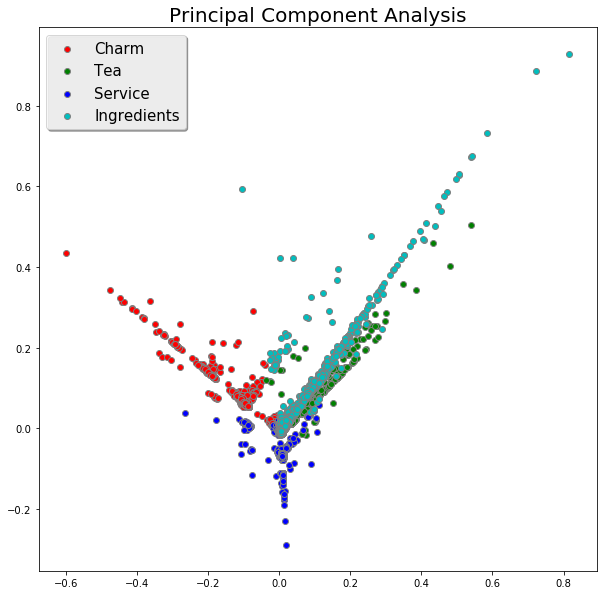

In [37]:
plot_PCA_2D(pcafeatures, target=np.asarray(component.y), target_names=topics)

# Explore topics

In [38]:
merged = pd.merge(df, component, on = 'review_id')

In [39]:
df = merged

**Explore how topics vary by subgroups**:  
* Elite (ever)
* Superelite (at least 5 years)
* Metro area
* Review usefulness
* Chain

In [40]:
# Rename topics - count both Topic 2 & 4 as "ingredients"
topics = {"topic": {"component_1": "charm", "component_2": 'ingredients', 
                    "component_3": 'service', "component_4": 'ingredients'}}

df.replace(topics, inplace = True)

In [41]:
topics = pd.get_dummies(df['topic'])
df = df.join(topics)

In [42]:
df=df.rename(columns = {'useful_x':'useful_count'})

In [43]:
df.useful_count.describe()

count    26388.000000
mean         1.008906
std          3.373925
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        219.000000
Name: useful_count, dtype: float64

In [44]:
df['elite_bin'] = df.elite_years_count.apply(lambda x: 1 if x>0 else 0)
df['superelite'] = df.elite_years_count.apply(lambda x: 1 if x>=5 else 0)
df['useful_bin'] = df.useful_count.apply(lambda x: 1 if x>=2.0 else 0)

In [45]:
df.useful_bin.value_counts()

0    21290
1     5098
Name: useful_bin, dtype: int64

In [46]:
df.groupby(['elite_bin']).topic.value_counts(normalize = True)

elite_bin  topic      
0          service        0.423889
           charm          0.357687
           ingredients    0.218424
1          charm          0.379044
           service        0.319691
           ingredients    0.301264
Name: topic, dtype: float64

In [47]:
df.groupby(['superelite']).topic.value_counts(normalize = True)

superelite  topic      
0           service        0.396101
            charm          0.362599
            ingredients    0.241300
1           charm          0.384025
            service        0.322581
            ingredients    0.293395
Name: topic, dtype: float64

In [48]:
df.groupby(['stars_review', 'elite_bin']).topic.value_counts(normalize = True)

stars_review  elite_bin  topic      
1.0           0          service        0.729167
                         ingredients    0.143229
                         charm          0.127604
              1          service        0.626344
                         ingredients    0.247312
                         charm          0.126344
2.0           0          service        0.600241
                         charm          0.223359
                         ingredients    0.176400
              1          service        0.470812
                         ingredients    0.302030
                         charm          0.227157
3.0           0          service        0.401413
                         charm          0.336080
                         ingredients    0.262507
              1          ingredients    0.342857
                         service        0.337343
                         charm          0.319799
4.0           0          charm          0.423499
                         service

In [49]:
df.groupby(['state']).topic.value_counts(normalize = True)

state  topic      
AZ     service        0.509818
       charm          0.303188
       ingredients    0.186995
NC     charm          0.482600
       service        0.353250
       ingredients    0.164150
NV     service        0.441617
       ingredients    0.318535
       charm          0.239848
OH     charm          0.475101
       service        0.345222
       ingredients    0.179677
ON     charm          0.430759
       ingredients    0.318394
       service        0.250846
PA     charm          0.546187
       service        0.229275
       ingredients    0.224538
WI     charm          0.482679
       service        0.301386
       ingredients    0.215935
Name: topic, dtype: float64

In [50]:
for i in range(21):
    df['useful_bin'] = df.useful_count.apply(lambda x: 1 if x>=i else 0)
    print(df[df.useful_bin == 1].ingredients.mean())

0.2477262392
0.260290225427
0.277755982738
0.301611090296
0.313873195229
0.333333333333
0.33642384106
0.348880597015
0.355450236967
0.367781155015
0.382575757576
0.398190045249
0.402173913043
0.412121212121
0.409722222222
0.433070866142
0.441666666667
0.455357142857
0.463157894737
0.458823529412
0.480519480519


In [51]:
df['useful_bin'] = df.useful_count.apply(lambda x: 1 if x>=2.0 else 0)

In [52]:
df.loc[(df.useful_bin == 1) & (df.stars_review > 4.0)].topic.value_counts(normalize = True)

charm          0.472239
service        0.266269
ingredients    0.261493
Name: topic, dtype: float64

In [53]:
for i in ['Starbucks', "Dunkin' Donuts"]:
    print(df.loc[df.name_x == i].topic.value_counts(normalize = True))

service        0.650182
charm          0.183152
ingredients    0.166667
Name: topic, dtype: float64
service        0.775693
charm          0.120643
ingredients    0.103664
Name: topic, dtype: float64


In [54]:
df.to_csv('Tableau.csv')